In [1]:
import numpy as np
from astropy import constants as ca
from funcs.blackbody_model import _brightness_mod, brightness_mod_continous
from funcs.probabilities_emcee import log_loglikelihood, log_likelihood, log_logprior_global_uniform, \
      plot_corner_emcee, plot_walker_emcee, display_median_from_chain,  log_logprobability, log_logprior_peak_uniform
import sys 
import matplotlib.pyplot as plt
import astropy.units as u

In [2]:
#import brightness and error for each Flare and TRAPPIST-1
flare1 = np.genfromtxt("../results/values/brightnesstot_peak_flare1_TRAPPIST-1.txt",delimiter="," , skip_header=1)
flare2 = np.genfromtxt("../results/values/brightnesstot_peak_flare2_TRAPPIST-1.txt",delimiter="," , skip_header=1)
trappist = np.genfromtxt("../results/values/brightness_TRAPPIST-1.txt", delimiter= ",", skip_header=1)
trappist_SED = np.genfromtxt("../data/TRAPPIST1_Semimodel_Wilson/TRAPPIST-1_model_const_res_v07.ecsv")
trappistflux_M2 = np.genfromtxt("../results/values/brightness_TRAPPIST-1_withCCDeffeciency.txt", delimiter= ",", skip_header=1)

In [3]:
#import flare brightness and spectral energy dist. in M2
wavelength_SED, flux_SED = trappist_SED[:,0]*1e-10, trappist_SED[:,1]
brightness_flares, brightnesserror_flares = np.reshape(np.concatenate((flare1[0],flare2[0])), (2,4)), \
                                            np.reshape(np.concatenate((flare1[1], flare2[1])), (2,4))
#flux/brighntess is in erg cm-2 -s

#Import M2 response, passband limits
iters = ["g", "r", "i", "z"]
limit, wavelength_M2, response_M2 = [], [], []

for i in iters: 
    #limit are the limits of the passband in wavelength 
    limit.append(np.load("../data/MuSCAT2_response/MuSCAT2_limit_{}.npy".format(str(i))))
    wavelength_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_wavelength_{}.npy".format(str(i))))
    response_M2.append(np.load("../data/MuSCAT2_response/MuSCAT2_response_{}_bandpass.npy".format(str(i))))

In [4]:
#Convert to correct unit
brightness_flares = brightness_flares* u.erg *u.s**(-1) * u.cm**(-2)
brightnesserror_flares = brightnesserror_flares * u.erg *u.s**(-1) * u.cm**(-2)
brightness_flares = brightness_flares.to("W/m^2")
brightnesserror_flares = brightnesserror_flares.to("W/m^2")

brightness_flares = brightness_flares.to("W/m^2").value
brightnesserror_flares = brightnesserror_flares.to("W/m^2").value 

In [5]:
flux_SED = flux_SED * u.erg * u.s**(-1) *u.cm**(-2) * u.Angstrom**(-1)
flux_SED = flux_SED.to("W m^-3")
flux_SED = flux_SED.value

In [6]:
###################################
from scipy.optimize import minimize

#Define parameters of the TRAPPIST-1
parameters_op = []
t_star = 2648 #[K] #Wilson et al 2021
r_star = 0.1192 * ca.R_sun.value
dist_star = dist_TRAP = 3.835084e+17 #[m]

#initial values for MCMC
for i in range(len(brightness_flares)):
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([10000,0.1] + 0.01 * np.random.randn(2))
    soln = minimize(nll, initial, args=(wavelength_SED, brightness_flares[i], \
                                        brightnesserror_flares[i], limit, flux_SED, \
                                        t_star, r_star, dist_star))
    T_op, a_op = soln.x 
    
    #ensure Temperature is not to high
    if T_op > 55000 or T_op < 3000:
        T_op = 10000 
        
    #ensure fraction of area is not negative
    if a_op < 0:
        a_op = 1e-6
    
    parameters_op.append([T_op, a_op])

parameters_op = np.asarray(parameters_op)

In [7]:
parameters_op 

array([[1.34142718e+04, 5.45880135e-01],
       [8.19807433e+03, 2.17378747e-01]])

In [8]:
import emcee
import corner
import matplotlib.pyplot as plt


n = 25000 #number of steps in the chain
ndim = 2 #dimensions of the model i.e. parameters in the model
nwalkers = 40 #number of walkers

samples_total, samplesflat_total = [],[] 

#Emcee Flare fitting
for i in range(len(brightness_flares)):
    sys.stdout.write("Flare #" + str(i+1))
    
    pos = np.log10(parameters_op[i] + 1e-7 * np.random.randn(nwalkers, ndim))
    
    
    
    #sampler
    sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_logprobability, args=(wavelength_SED, brightness_flares[i],\
                                                       brightnesserror_flares[i], limit, flux_SED, \
                                                       t_star, r_star, dist_star, log_logprior_peak_uniform))
    sampler.run_mcmc(pos, n, progress=True, )
    
    #flattensamples and discard burn in phase
    samplesflat_total.append(sampler.get_chain(discard=1000, thin=15, flat=True))
    samples_total.append(sampler.get_chain())
    

Flare #1

  0%|                                        | 10/25000 [00:00<04:24, 94.56it/s]

Flare #2

100%|█████████████████████████████████████| 25000/25000 [04:28<00:00, 93.21it/s]


In [9]:
#Write chain data to arrays 

np.save("../data/MCMC/logsamples_peak", samples_total, allow_pickle=True, fix_imports=True)
np.save("../data/MCMC/logsamplesflat_peak", samplesflat_total, allow_pickle=True, fix_imports=True)

In [7]:
#Load data from chain 

samples_total = np.load("../data/MCMC/logsamples_peak.npy")
samplesflat_total = np.load("../data/MCMC/logsamplesflat_peak.npy")

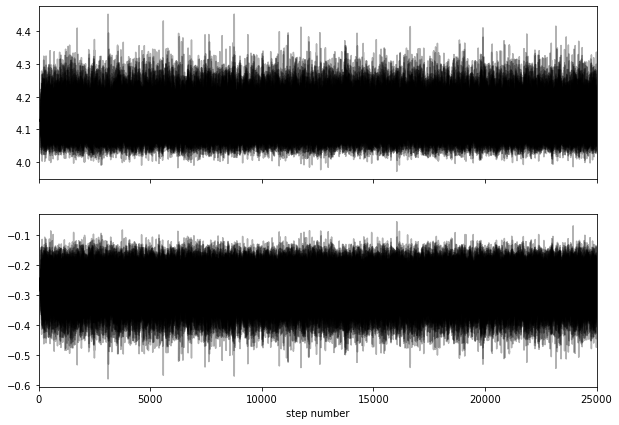

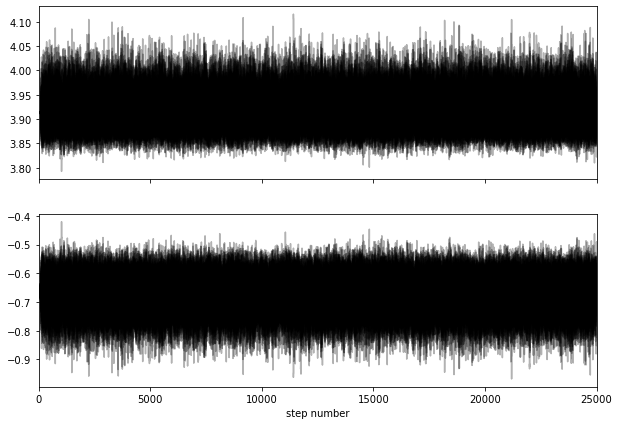

In [10]:
plot_walker_emcee(samples_total)

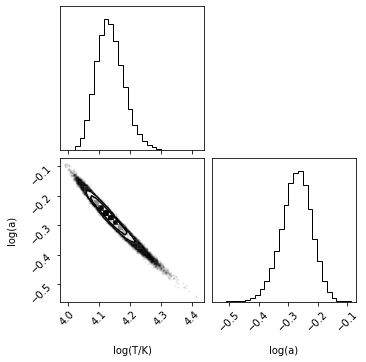

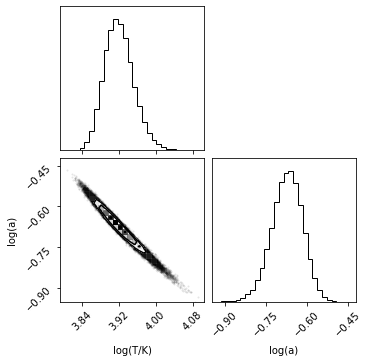

In [12]:
plot_corner_emcee(samplesflat_total,bins=30,labels=["log(T/K)","log(a)"])

In [13]:
results = display_median_from_chain(samplesflat_total)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [120]:
T_med = 10**results[0][0]
a_med = 10**results[2][0]


T_high = 10**(results[0][0] + results[1][0][1])
T_low = 10**(results[0][0] - results[1][0][0])
a_high = 10**(results[2][0] + results[3][0][0])
a_low = 10**(results[2][0] - results[3][0][0])


In [121]:
T_med2 = 10**results[0][1]
a_med2 = 10**results[2][1]


T_high2 = 10**(results[0][1] + results[1][1][1])
T_low2 = 10**(results[0][1] - results[1][1][0])
a_high2 = 10**(results[2][1] + results[3][1][0])
a_low2 = 10**(results[2][1] - results[3][1][0])

In [124]:
T_med, T_med - T_low, T_high - T_med 

(13611.34481383749, 1216.752042378239, 1568.4377907969483)

In [125]:
T_med2, T_med2 - T_low2, T_high2 - T_med2 

(8281.691652381838, 545.7631224574234, 658.7864915562823)

In [126]:
a_med, a_med - a_low, a_high - a_med

(0.5363145349867854, 0.06144288590413621, 0.06939288299392166)

In [127]:
a_med2, a_med2 - a_low2, a_high2 - a_med2

(0.21327007585458763, 0.026513075088009097, 0.030277020470174443)

In [118]:
wavelength = wavelength_SED[100:14000]
flux = flux_SED[100:14000]

inds = np.random.randint(len(samplesflat_total[0]), size=100) #
import warnings
warnings.filterwarnings("ignore")

temperatures_flare1 = np.zeros([100,len(wavelength)])
temperatures_flare2 = np.zeros([100,len(wavelength)])
i=0
for ind in inds:
    sample = samplesflat_total[0][ind]
    temperatures_flare1[i] = 1e6*brightness_mod_continous(wavelength,10**sample[0],10**sample[1], \
                                          flux,t_star,r_star, dist_star, model = None)
    i = i+1

i=0
for ind in inds:
    sample = samplesflat_total[1][ind]
    temperatures_flare2[i] = 1e6*brightness_mod_continous(wavelength,10**sample[0],10**sample[1], \
                                          flux,t_star,r_star, dist_star, model = None)
    i = i+1
    

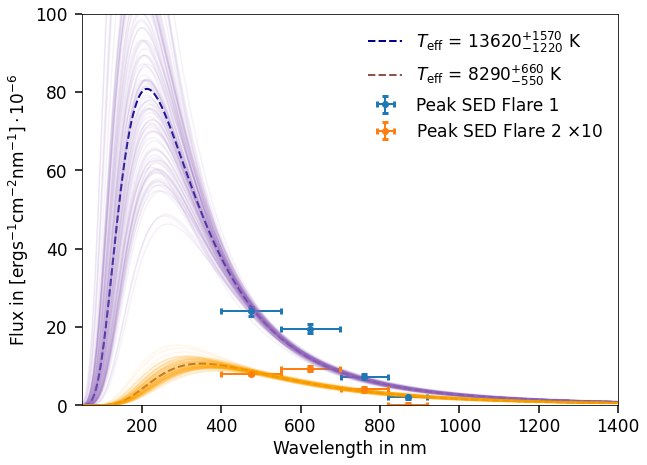

In [131]:
#need to change units at the moment W/m^2


lc = [4.745e-07, 6.245e-07, 7.6e-07, 8.695000000000001e-07]
ranges = np.asarray([1.4999999999999994e-07, 1.5000000000000005e-07, 1.1900000000000005e-07, 1e-07])/2*1e9
#sum of datapoints in wavelength array for continous model
limitss = np.asarray([limit[0][1] - limit[0][0], limit[1][1] - limit[1][0] , limit[2][1] - limit[2][0], \
                      limit[3][1] - limit[3][0]]) 

import matplotlib.pyplot as plt
from matplotlib import rcParams  #ticks for axes
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams["figure.figsize"] = [9.6, 7.2] 
rcParams.update({'font.size': 17})

#plt.figure(figsize=(12,9.6))
plt.rcParams['font.size'] = '17'


plt.errorbar(np.asarray(wavelength_M2)*1e9,1e6*brightness_flares[0]/limitss, xerr = ranges, yerr = 1e6*brightnesserror_flares[0]/limitss ,fmt=".", color = "tab:blue", \
                        ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = "Peak SED Flare 1")

plt.plot(wavelength_SED*1e9,  \
         1e6*brightness_mod_continous(wavelength_SED, T_med, a_med, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $13620^{+1570}_{-1220}$ K", linewidth = 2, color = "darkblue") #, array([5127.88550742]


for i in range(100):
    plt.plot(wavelength_SED[100:14000]*1e9,temperatures_flare1[i], color = "tab:purple", alpha = 0.09)  
        


plt.xlim(100,1000)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-12}$")



plt.errorbar(np.asarray(wavelength_M2)*1e9,10*brightness_flares[1]*1e6/limitss, xerr = ranges, yerr = 10*brightnesserror_flares[1]*1e6/limitss ,color="tab:orange", \
                         ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = r"Peak SED Flare 2 $\times 10$")

plt.plot(wavelength_SED*1e9,  \
         1e6*10*brightness_mod_continous(wavelength_SED, T_med2, a_med2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $8290^{+660}_{-550}$ K", linewidth = 2, color = "tab:brown") #, array([5127.88550742]


for i in range(100):
    plt.plot(wavelength_SED[100:14000]*1e9,10*temperatures_flare2[i], color = "orange", alpha = 0.09)  
        

plt.xlim(50,1400)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-6}$") #W/^3 --> erg/cm^2/s^1/nm
plt.ylim(0,100)

plt.legend(loc = "upper right",frameon = False) 

plt.savefig("../results/plots/paper_appendix_figureC2.png")


In [16]:
results

([4.1339010360318245, 3.918119056622528],
 [array([0.04066877, 0.04736452]), array([0.02960661, 0.03324169])],
 [-0.2705804327982303, -0.6710700765848849],
 [array([0.05284333, 0.04827944]), array([0.05765303, 0.05361111])])

In [103]:
params_1 = np.asarray([4.13390, 3.918100]) 
params_2 = np.asarray([-0.2705,  -0.671])

In [114]:
import corner
import matplotlib.lines as mlines
def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)

params_p50s=[params_1,params_2] #Truth parameters


CORNER_KWARGS = dict(
    smooth=0.9,
    label_kwargs=dict(fontsize=11),
    title_kwargs=dict(fontsize=11),
    quantiles=[0.16, 0.5,0.84],
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2)), #1-sig & 2-sig
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    show_titles=False,
    max_n_ticks=3,
)


def overlaid_corner(samples_list, sample_labels, sample_colors,param_labels,params_p50s=params_p50s):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    # cmap = plt.cm.get_cmap('gist_rainbow', n)
    colors = sample_colors#[cmap(i) for i in range(n)]

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        truths=[*params_p50s[0]],
        labels=param_labels,
        truth_color=colors[0], bins = 100,
        titles = [r"$10_2^1$", r"$10_1^2$"],
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            truths=[*params_p50s[idx]],
            truth_color=colors[idx], bins = 100,
            titles = [r"$10_2^1$", r"$10_1^2$"],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=13, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
    #print('corner_pRT'+perfix+'_final.pdf')
    #plt.savefig('corner_pRT'+perfix+'_final.pdf',bbox_inches=0.)
    #plt.close()

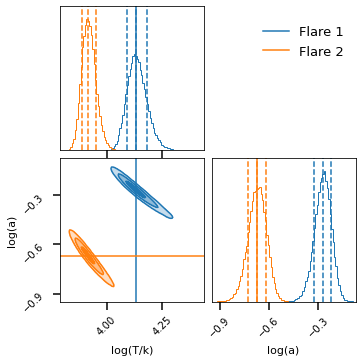

In [132]:
%matplotlib inline

overlaid_corner(samplesflat_total,["Flare 1", "Flare 2"],["tab:blue", "tab:orange"], ["log(T/k)", "log(a)"])

plt.savefig("../results/plots/paper_appendix_figureC3.png")

# ------------------------------ Note needed ----------------------

In [ ]:
#need to change units at the moment W/m^2


lc = [4.745e-07, 6.245e-07, 7.6e-07, 8.695000000000001e-07]
ranges = np.asarray([1.4999999999999994e-07, 1.5000000000000005e-07, 1.1900000000000005e-07, 1e-07])/2*1e9
#sum of datapoints in wavelength array for continous model
limitss = np.asarray([limit[0][1] - limit[0][0], limit[1][1] - limit[1][0] , limit[2][1] - limit[2][0], \
                      limit[3][1] - limit[3][0]]) 

import matplotlib.pyplot as plt
from matplotlib import rcParams  #ticks for axes
rcParams.update({'xtick.major.pad': '5.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams["figure.figsize"] = [9.6, 7.2] 
rcParams.update({'font.size': 17})

#plt.figure(figsize=(12,9.6))
plt.rcParams['font.size'] = '17'

#4890.07968612]), array([5086.15002762
up = 1e17*brightness_mod_continous(wavelength_SED,T_high, a_high, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)
low = 1e17*brightness_mod_continous(wavelength_SED,T_low, a_low, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)


plt.errorbar(np.asarray(wavelength_M2)*1e9,1e17*brightness_flares[0]/limitss, xerr = ranges, yerr = 1e17*brightnesserror_flares[0]/limitss ,fmt=".b", \
                         ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = "SED Flare 1")

plt.plot(wavelength_SED*1e9,  \
         1e17*brightness_mod_continous(wavelength_SED, T_med, a_med, trappist_SED[:,1], t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $13650^{+1550}_{-1250}$ K", linewidth = 2, color = "darkblue") #, array([5127.88550742]

plt.fill_between(wavelength_SED*1e9, up, low, facecolor = "purple", alpha = 0.15)

plt.xlim(100,1000)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-12}$")



up2 = 10*brightness_mod_continous(wavelength_SED,T_high2, a_high2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)*1e17
low2 = 10*brightness_mod_continous(wavelength_SED,T_low2, a_low2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None)*1e17

plt.errorbar(np.asarray(wavelength_M2)*1e9,10*brightness_flares[1]*1e17/limitss, xerr = ranges, yerr = 2.5*brightnesserror_flares[1]*1e17/limitss ,color="orange", \
                         ls = 'None', marker = 'o', linewidth = 2 , capsize=3, capthick=3,  label = r"SED Flare 2 $\times 10$")

plt.plot(wavelength_SED*1e9,  \
         1e17*10*brightness_mod_continous(wavelength_SED, T_med2, a_med2, flux_SED, t_star, R_star = r_star, dist_star = dist_star, model = None), ls = "dashed",\
         label = r"$T_\mathrm{eff}$ = $8300^{+700}_{-550}$ K", linewidth = 2, color = "brown") #, array([5127.88550742]



plt.fill_between(wavelength_SED*1e9, up2, low2, facecolor = "brown", alpha = 0.15,)

plt.xlim(50,1400)

plt.xlabel("Wavelength in nm")
plt.ylabel(r"Flux in $[\mathrm{erg} \mathrm{s}^{-1} \mathrm{cm}^{-2} \mathrm{nm}^{-1}] \cdot 10^{-11}$") #W/^3 --> erg/cm^2/s^1/nm
plt.ylim(0,90)

plt.legend(loc = "upper right",frameon = False) 